# HVImpactScore Example Notebook

In [1]:
# This notebook is intended to serve as a demo/example on how to use 
# the HVImpactScoring library to compare HVI debris clouds.

# The required analysis data and experimental data is included on the library's
# Github page. To perform this demo, you will need the cropped experimental image and x, y, z 
# final positions from the analysis. If import errors occur, check that the file paths are aligned.

# Use the help([function or class]) command for detailed definitions and further clarification of
# functions and classes in the HVImpactScore library.

In [7]:
# Import required dependencies.
# Common Python libraries.
import copy
import math
import numpy as np

# HVImpactScore library. Use pip to install if you haven't already.
import HVImpactScore

# Plotting import and formatting settings.
import matplotlib.pyplot as plt
%matplotlib inline
# Settings for jupyter book: svg for html version, high-resolution png for pdf
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

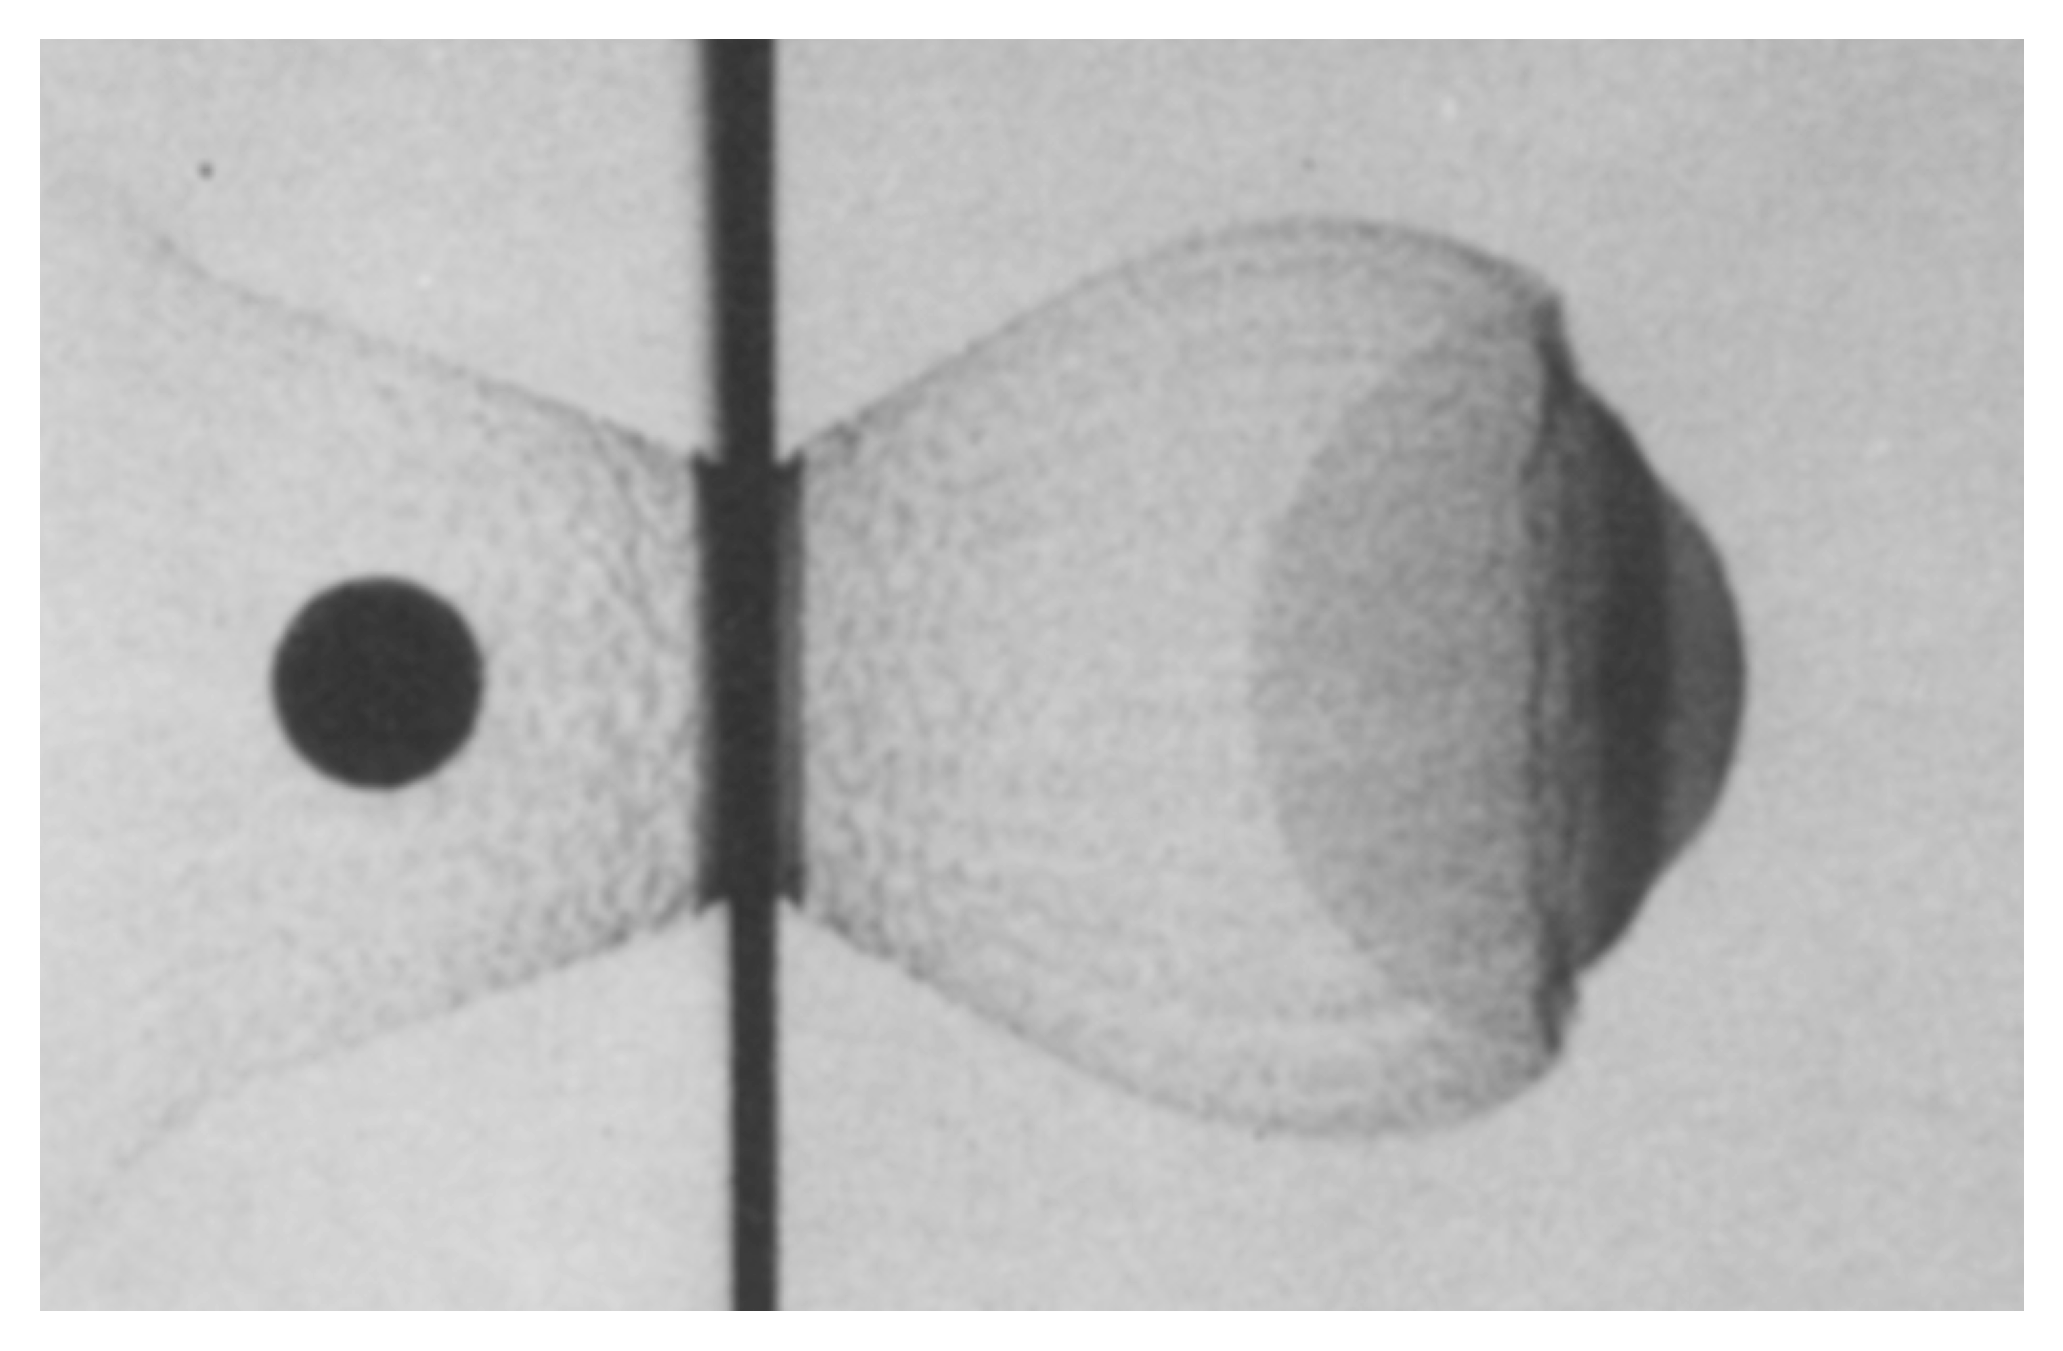

In [4]:
# Import and normalize experimental image.
exp_image = HVImpactScore.ImageProcessing.load_exp_image('Demo Data/Exp Data Image Piekutowski v2.png')

# Display the unprocessing image that's been imported
plot = plt.imshow(exp_image, cmap='gray', vmin=0.0, vmax=255.0)
plt.axis('off')
plt.show()

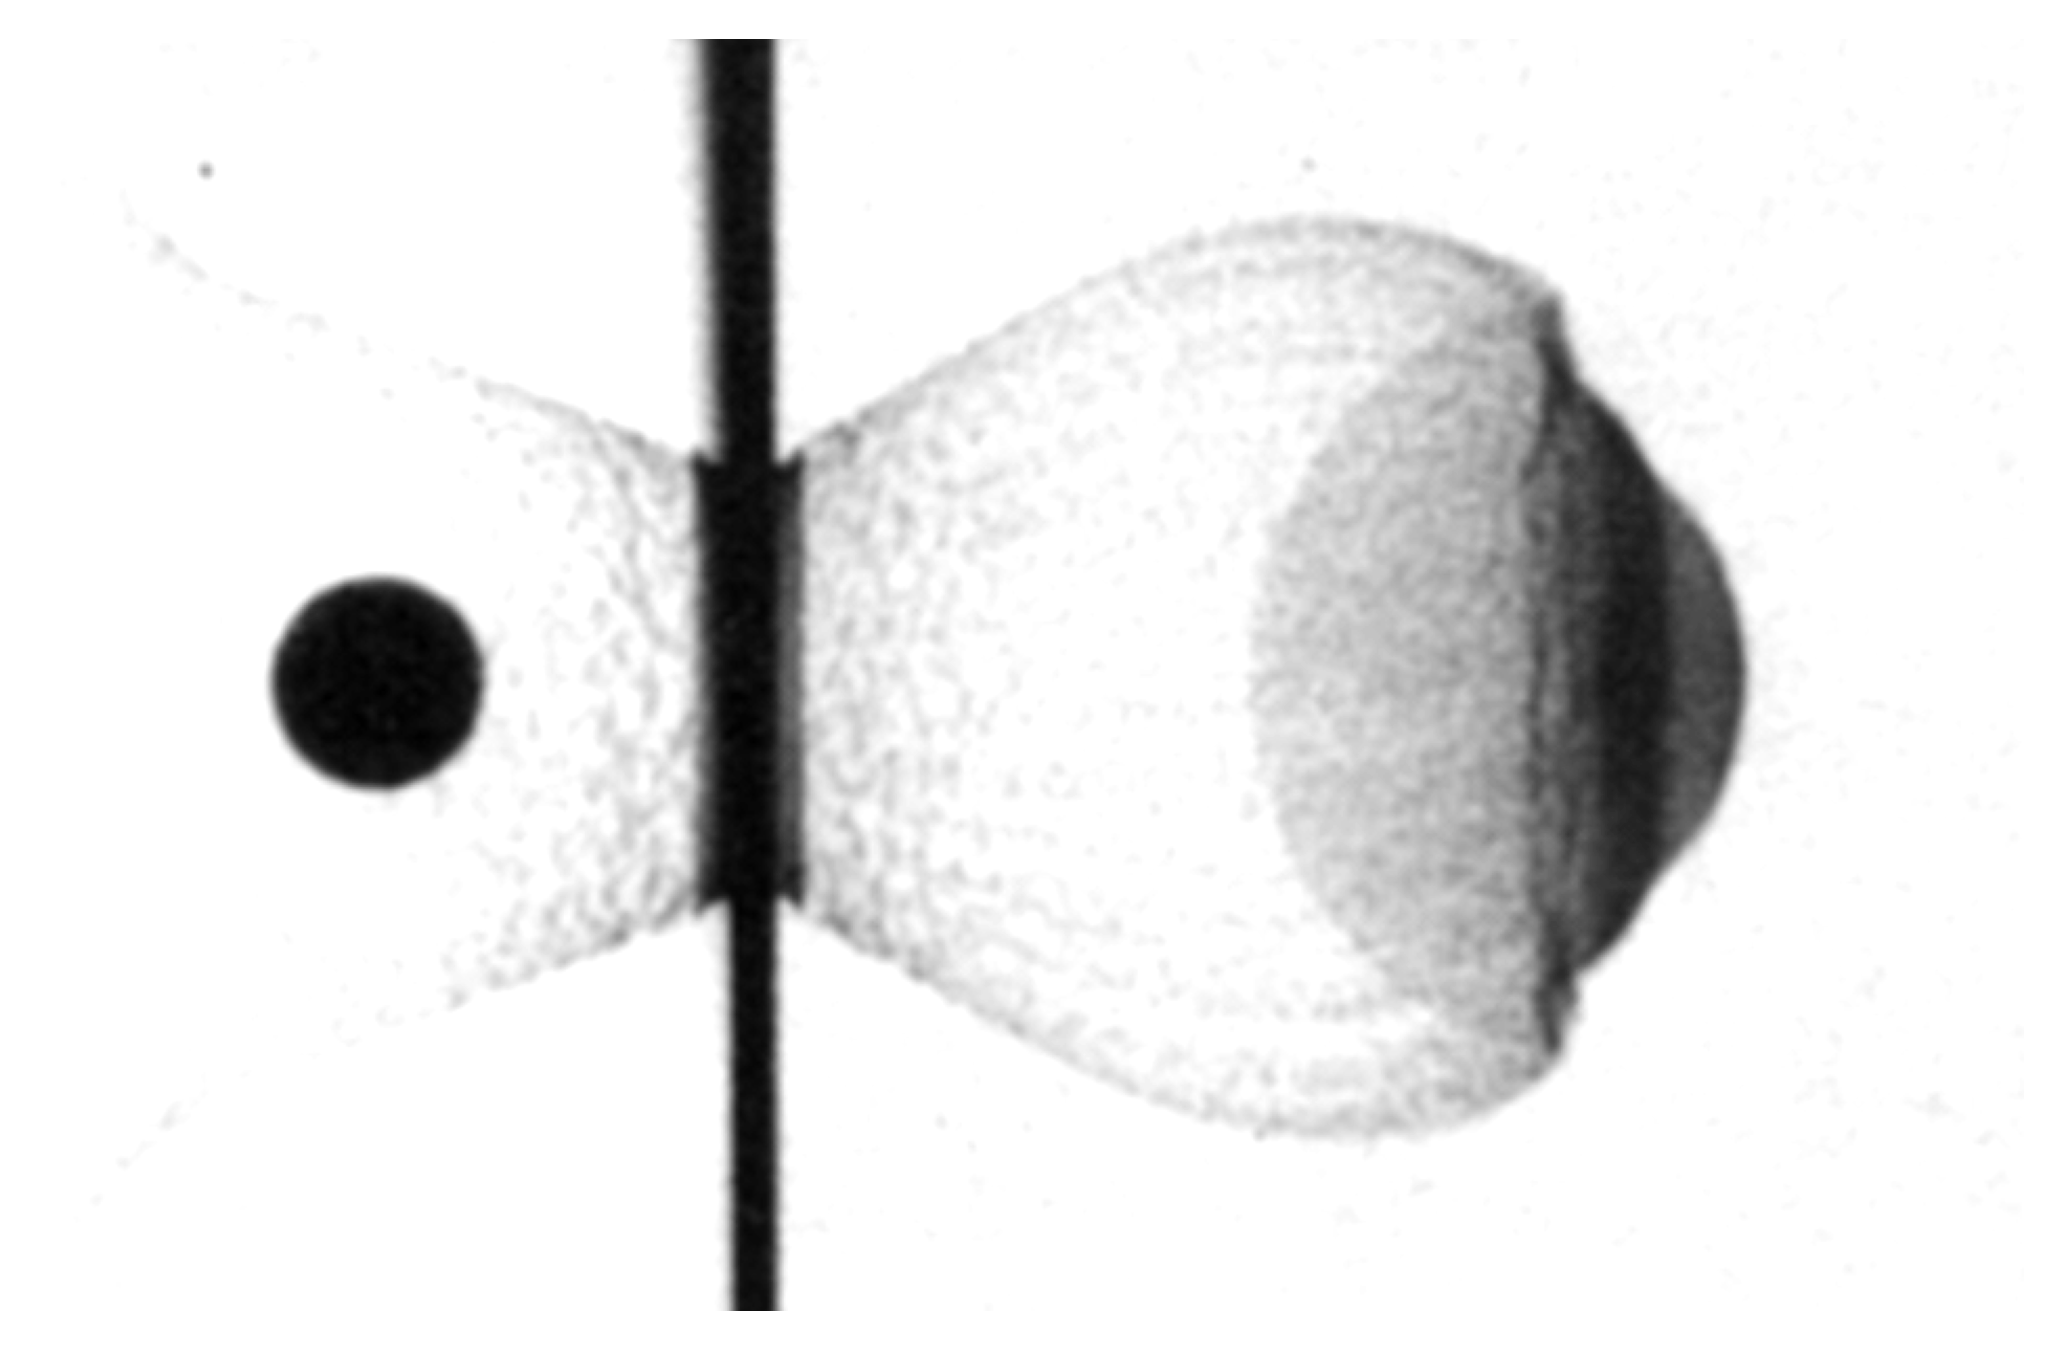

In [5]:
# Set the background sampling rectangle corners for the idw background removal.
bg_1_ul = [10, 80]
bg_1_lr = [30, 100]

bg_2_ul = [580, 80]
bg_2_lr = [600, 100]

bg_3_ul = [10, 460]
bg_3_lr = [30, 480]

bg_4_ul = [580, 460]
bg_4_lr = [600, 480]

bg_5_ul = [10, 880]
bg_5_lr = [30, 900]

bg_6_ul = [580, 880]
bg_6_lr = [600, 900]

# Combine the sample areas into an array
sample_area_array = [[bg_1_ul, bg_1_lr], [bg_2_ul, bg_2_lr], [bg_3_ul, bg_3_lr], [bg_4_ul, bg_4_lr], [bg_5_ul, bg_5_lr], [bg_6_ul, bg_6_lr]]

# Normalize the image to align intensity range to [0.0, 255.0]
norm_image = HVImpactScore.ImageProcessing.normalize_image(exp_image)

# Perform the background removal
no_bg_image = HVImpactScore.ImageProcessing.threshold_image_idw(norm_image,
                                                                    7.0,
                                                                    sample_area_array)

# Display the processed image
plot = plt.imshow(no_bg_image, cmap='gray', vmin=0.0, vmax=255.0)
plt.axis('off')
plt.show()

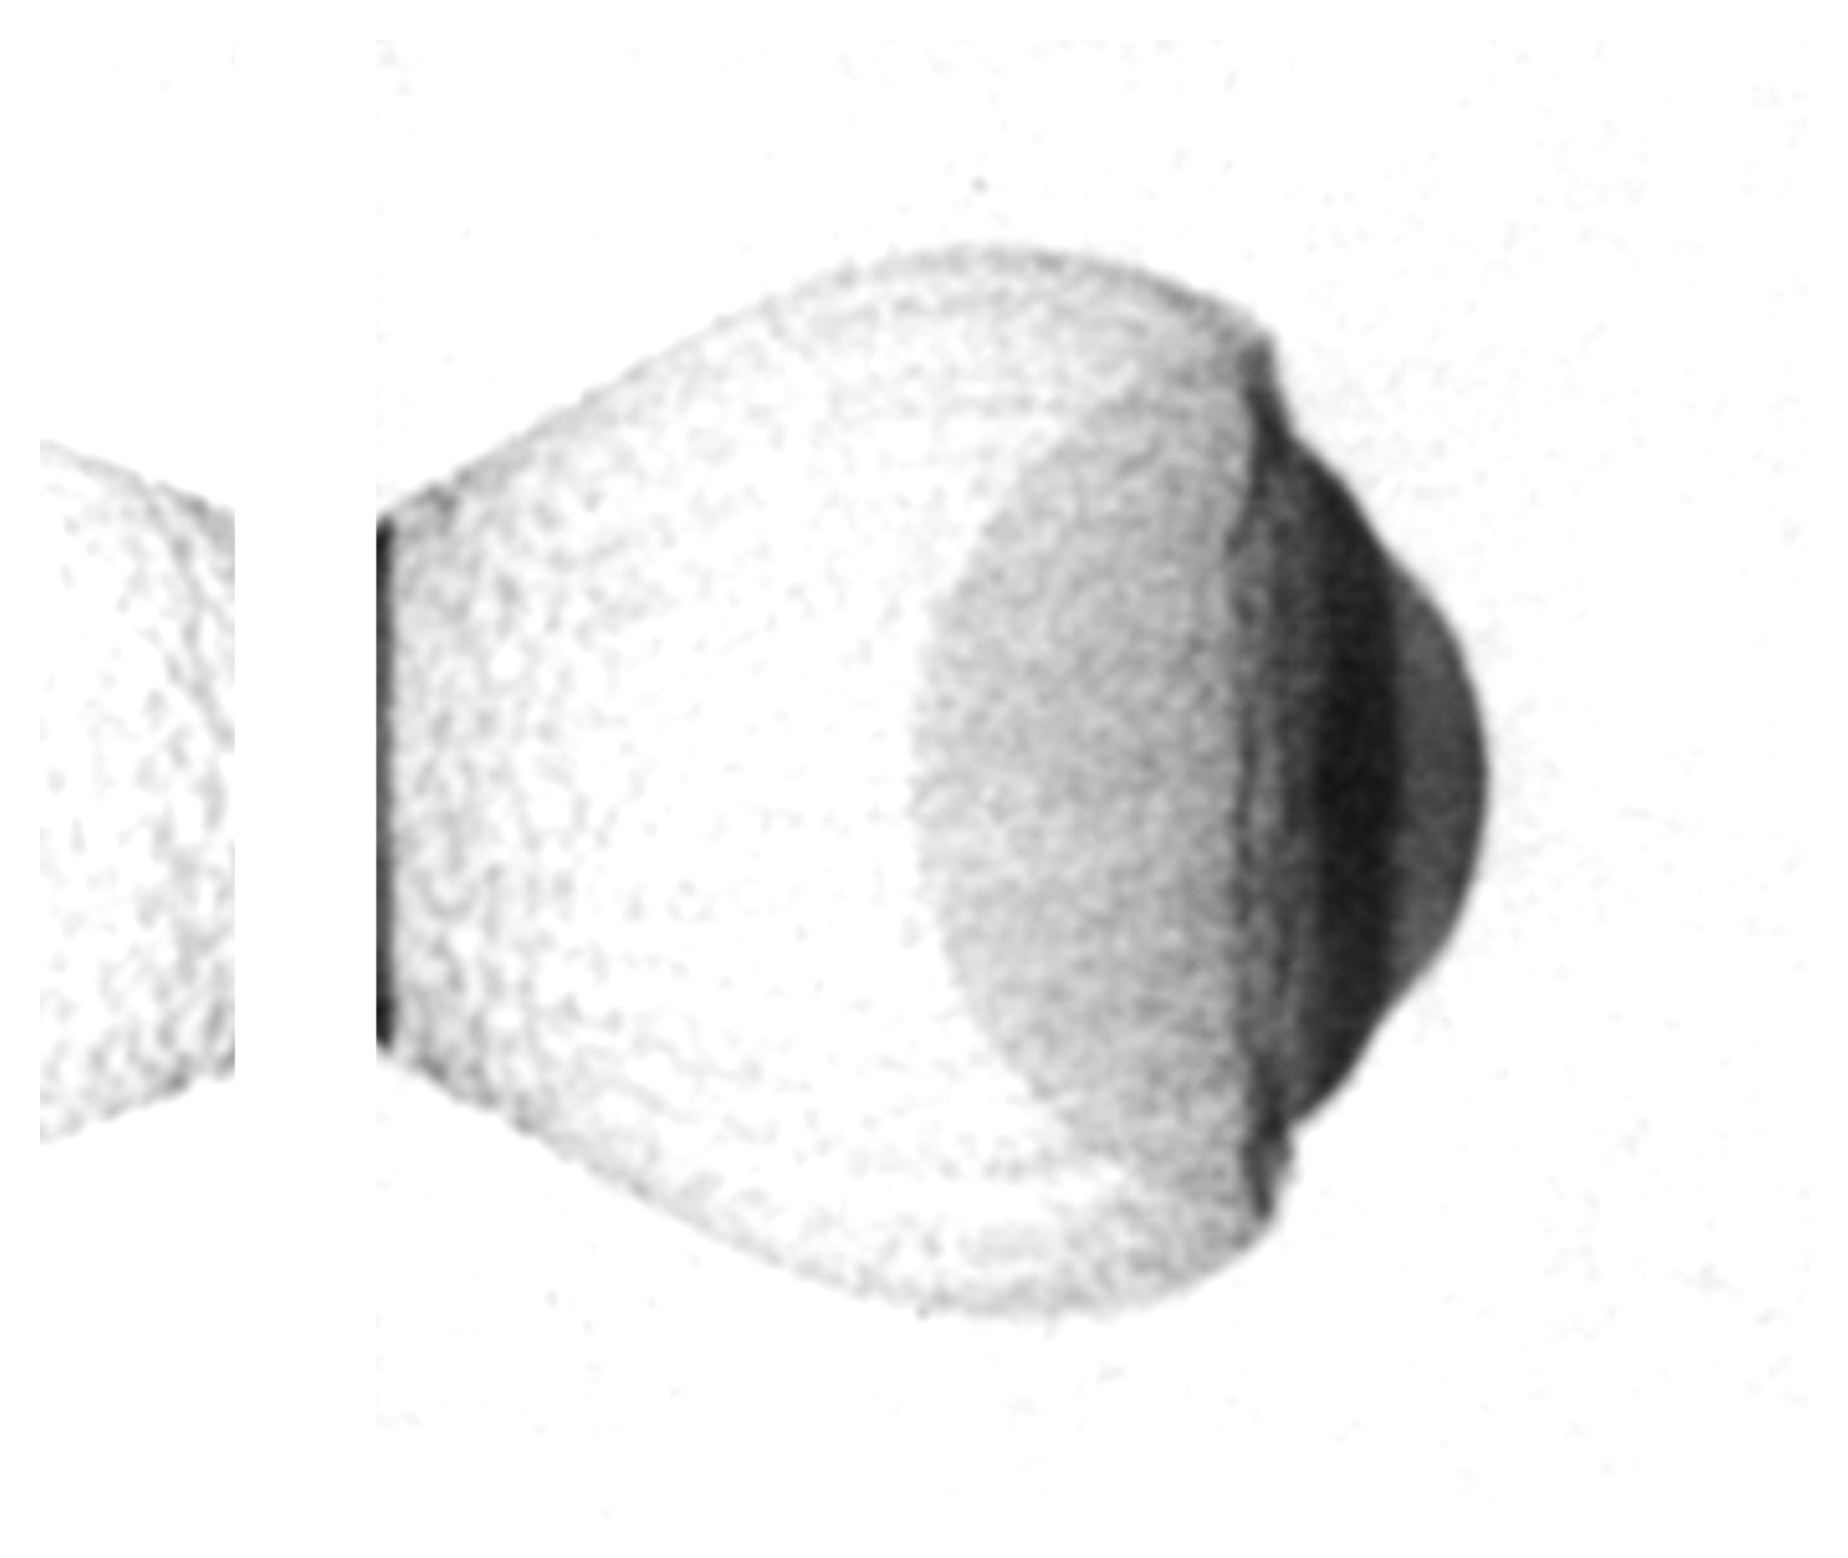

In [8]:
# Set the pixel pitch (pre-measured in this example).
pixel_pitch = 9.490616010434515e-05

# Crop out the projectile as it is from multiple XRF exposures.
fin_exp_image = no_bg_image[:,220:-1]

# Set the experimental coordinate system and debris cloud rotation (0.0 would be
# completely horizontal).
origin_x = 120
origin_y = 306
cloud_rot = 0.0008726

# Create variables to describe the pixel bounds from the coordinate system.
# Will be used when creating image from analysis data.
img_tot_height = np.shape(fin_exp_image)[0]
img_tot_width = np.shape(fin_exp_image)[1]

pix_y_neg = round(origin_y * -1.0)
pix_y_plus = img_tot_height + pix_y_neg

pix_x_neg = round(origin_x * -1.0)
pix_x_plus = img_tot_width + pix_x_neg

# Set rectangle corners to exclude the wall.
wall_exclude_ul = [0, 80]
wall_exclude_lr = [np.shape(fin_exp_image)[0], 138]
wall_exclude_bounds = [wall_exclude_ul[1], wall_exclude_lr[1]]

# Create a copy of the experimental, processed image with the wall excluded.
no_wall_exp_img = copy.deepcopy(fin_exp_image)
no_wall_exp_img[:,wall_exclude_bounds[0]:wall_exclude_bounds[1]] = 255.0

# Display the final, processed experimental image
plot = plt.imshow(no_wall_exp_img, cmap='gray', vmin=0.0, vmax=255.0)
plt.axis('off')
plt.show()

[4.51417106e-05]


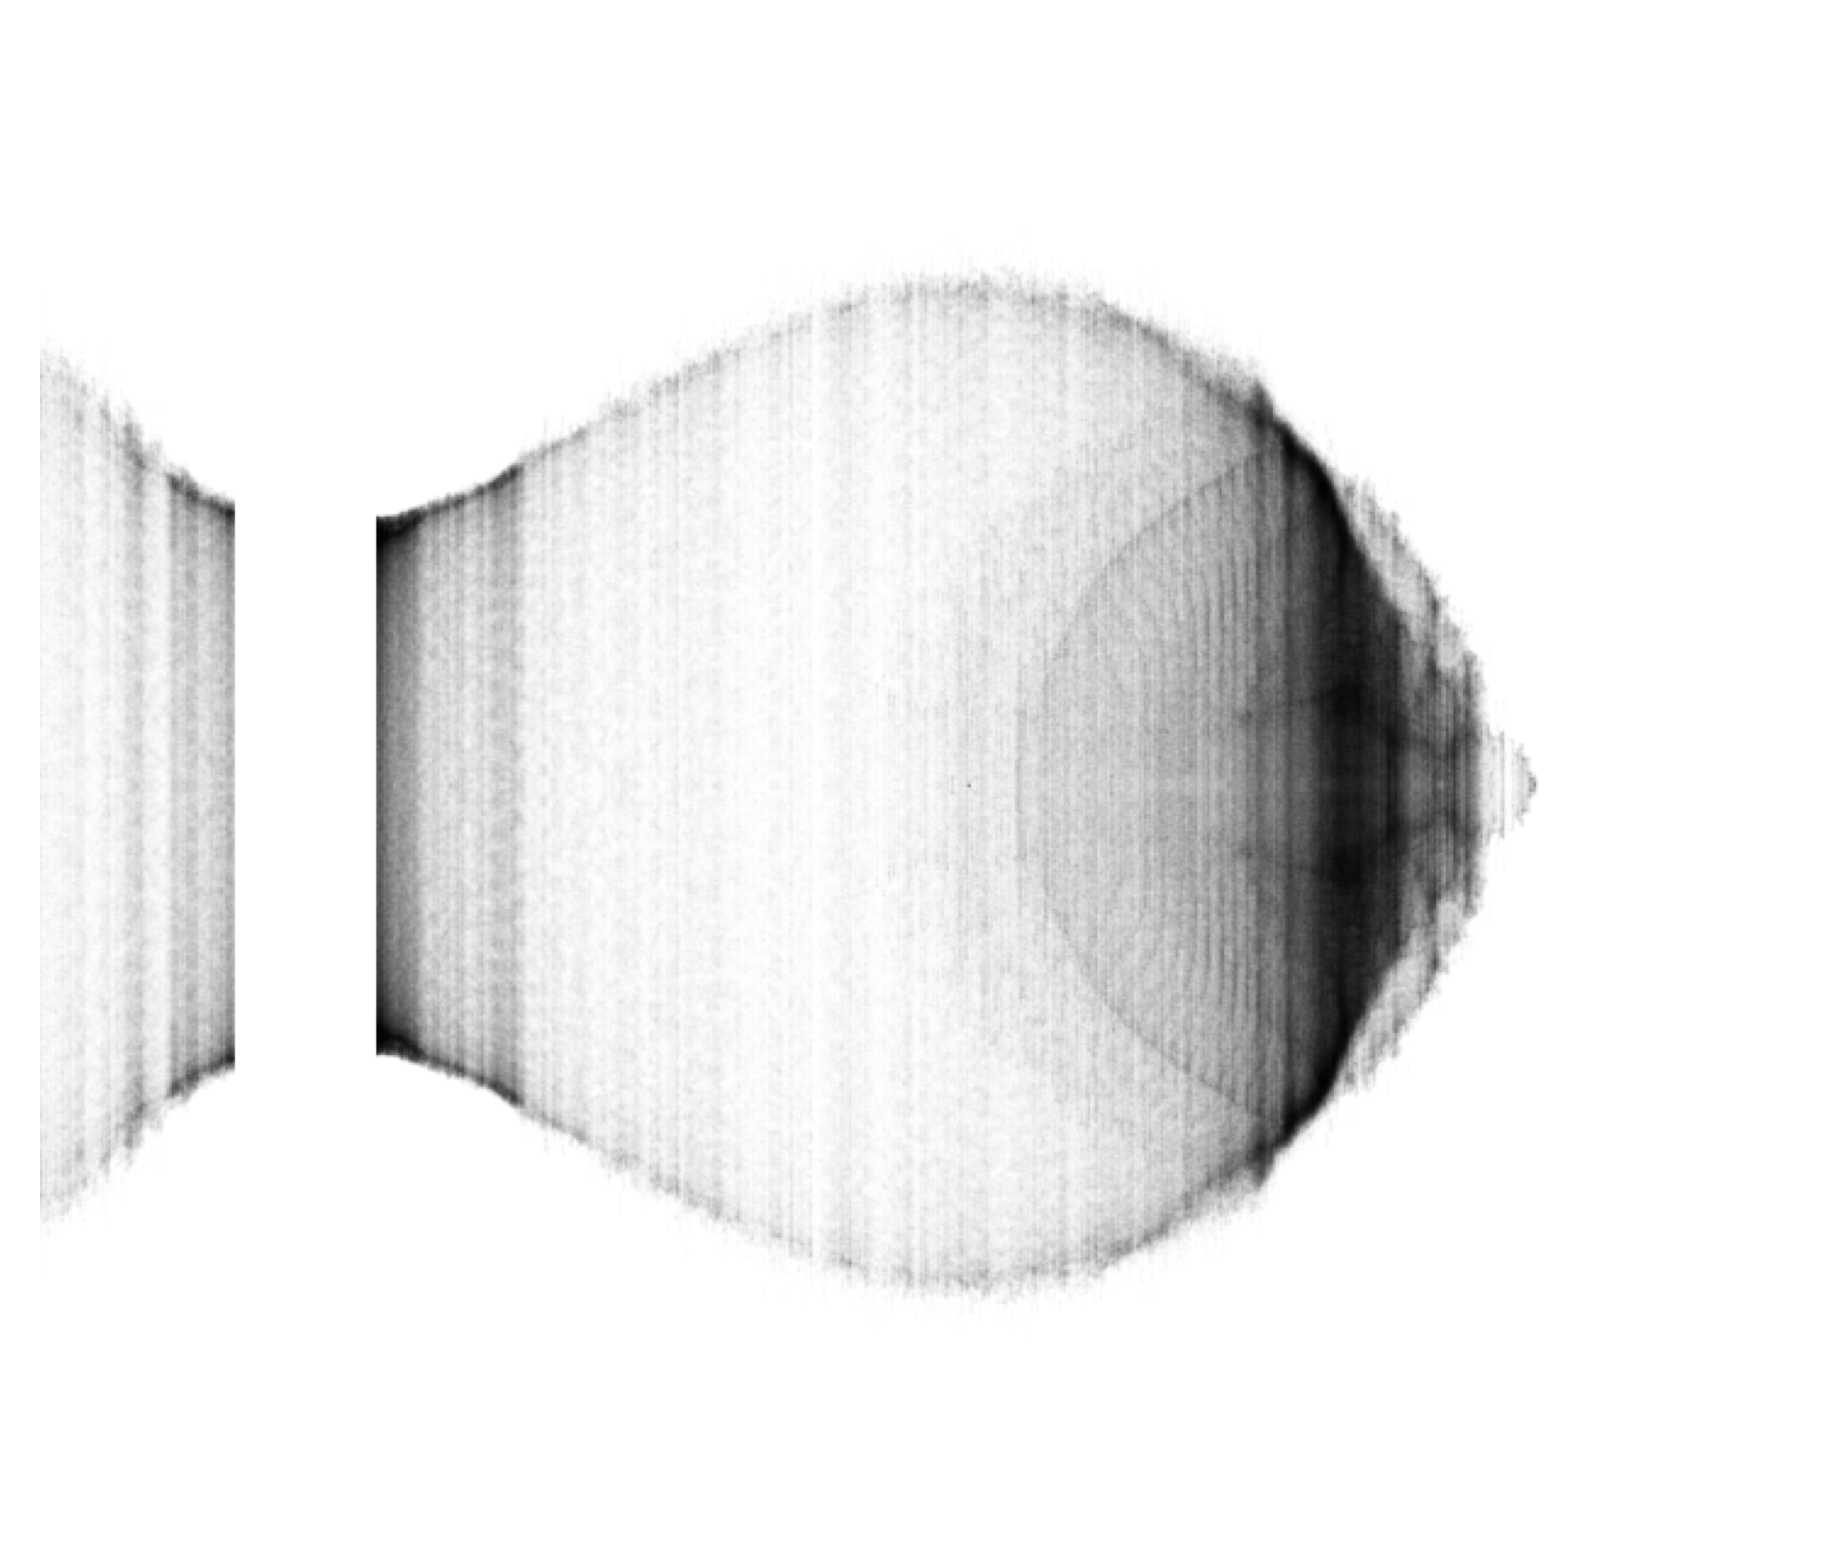

In [9]:
# Import analyais data
x_def_file = 'Demo Data/015 X Def.txt'
y_def_file = 'Demo Data/015 Y Def.txt'
z_def_file = 'Demo Data/015 Z Def.txt'

sph_data_set = HVImpactScore.SPHData()
sph_data_set.load_data(x_def_file,
                        y_def_file,
                        z_def_file,
                        1,
                        0.00015,
                        2700)

# Flip the data about the z-plane, otherwise debris cloud will face the opposite direction from experiment
sph_data_set.flip_data_zplane()

# Expand about the symmetry planes because analysis leveraged quarter symmetry.
sph_data_set.expand_sym_about_y_plane()
sph_data_set.expand_sym_about_x_plane()

# Generate the density map
# 29 additional random rotations
# 0.0 - Pi/2.0 rotational range
kernel = HVImpactScore.SPHDataProcessing.bspline_kernel
density_map = HVImpactScore.SPHDataProcessing.sph_data_to_dens_map_multi_rot(sph_data_set,
                                                                              kernel,
                                                                              0.00015 / 2.0,
                                                                              pixel_pitch,
                                                                              pix_x_neg,
                                                                              pix_x_plus,
                                                                              pix_y_neg,
                                                                              pix_y_plus,
                                                                              29,
                                                                              0.0,
                                                                              math.pi / 2.0,
                                                                              cloud_rot)

# Exclude the wall, using the same region as the experimental image for consistency
density_map_no_wall = density_map
density_map_no_wall[:,wall_exclude_bounds[0]:wall_exclude_bounds[1]] = 0.0

# Perform optimization of absorption coefficient b/c it is not provided in the literature.
light_abs_factor = HVImpactScore.ImageProcessing.find_abs_coefficient(density_map_no_wall,
                                                                          no_wall_exp_img,
                                                                          0.0001,
                                                                          1.0e-8)
print(light_abs_factor) # Should be approximately 4.54574005e-05

# Apply the calculated absorption coefficent to the density map to get the analysis image.
analysis_image_nm = HVImpactScore.ImageProcessing.apply_unit_light_absorbtion(density_map_no_wall,
                                                                               light_abs_factor)

# Perform a final normalization to align pixel intensity range.
analysis_image = HVImpactScore.ImageProcessing.normalize_image(analysis_image_nm)

# Display the analysis image
img = plt.imshow(analysis_image, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# Perform similarity scoring on the final experimental and analysis images.
score = HVImpactScore.scoring.score_images(analysis_image, no_wall_exp_img, 5.0)
print(score) # Should be approximately 0.863578

0.8656092599561891
